**UAS ANALISIS MEDIA SOSIAL**

**ANALISIS PENGELOMPOKAN NEGARA BERDASARKAN FOLKLORE MENGGUNAKAN ALGORITMA K-MEANS**


Dibuat oleh:

Bryan Ernestin \ 6162001097

Leonardo Alindra \ 6162001111

Wristopher \ 6162001147

Kelas B

Dataset folklore:

https://drive.google.com/file/d/1KW_yawDf5ZDYw0MLhqjZkCa9TSsEIDNl/view?usp=sharing

## **Import Library yang Dibutuhkan**

In [ ]:
!pip install geopandas

In [ ]:
!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Struktur Data
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Pemrosesan Corpus
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualisasi dan Analisis Data
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium

#import branca.colormap as cm
from branca.element import Figure

## **Corpus Loading**

Membaca file csv tentang folklore atau cerita rakyat menggunakan Pandas. Selanjutnya, ekstrak kolom "folklore" ke suatu list, yaitu corpus.

In [ ]:
data = pd.read_csv('Data_Folklore.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns) # Membuat nama kolom menjadi huruf kecil semua

data.head(5)

,country,alpha-2,alpha-3,continent,title,folklore
0,Armenia,AM,ARM,Europe,Dakhanavar,There once dwelt in a cavern in this country a...
1,China,CN,CHN,Asia,The Great Race,An ancient folk story tells that Cat (猫) and R...
2,Indonesia,ID,IDN,Asia,Malin Kundang,"One day, when Malin Kundang was sailing, he sa..."
3,Finland,FI,FIN,Europe,Näkki,​Näkki is the most well-known water spirit in ...
4,Thailand,TH,THA,Asia,Krasue,"One of Thailand’s most feared ghosts, Krasue w..."


In [ ]:
corpus = data['folklore'].tolist()
corpus[18][0:500]

'It is related that there was once a man who had the fortune to obtain a son, and he went to the akhund to get the boy\'s horoscope. The akhund told him: "Your son is fated to be torn in pieces by a wolf." The father went home and built an underground chamber and put his son in it. Then he procured an akhund and brought him to teach the child. In the course of some years the boy learned to read and write, and he grew up, and it became time for him to take a wife. His father\'s brother had a daughte'

## **Corpus Processing**

### 1. Stop Words and Stemming

Data masuk ke dalam proses pembersihan dan penyederhanaan. Menghilangkan stop words, yaitu kata-kata yang tidak berperan penting dalam proses clustering. Lalu, dilanjutkan dengan proses stemming, yaitu mengubah kata ke dalam bentuk dasarnya.

Kedua proses ini dilakukan supaya proses clustering nantinya dapat berjalan dengan efektif dan efisien.

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

### 2. The main corpus processing function

Menghilangkan unknown ASCII symbols, especial chars, numbers, e-mails, URLs, dan berbagai karakter lain yang tidak dibutuhkan dengan RegEx.

In [ ]:
def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase

        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

'relat man fortun obtain son akhund boy horoscop akhund told son fate torn piec wolf father home built underground chamber put son procur akhund brought teach child year boy learn read write grew time wife father brother daughter wed celebr day night end week brought bride underground chamber husband put hand hand leav sooner youth put arm round girl waist sudden turn wolf tore piec turn girl sat idea happen remain sit till morn daylight women found bride s'

### Statistical Weighting of Words

Memasukan data ke fungsi TF-IDF untuk memberikan bobot pada data. Bobot ini berupa nilai numerik dari 0 hingga 1 yang merepresentasikan seberapa penting suatu kata terhadap suatu dokumen dalam corpus.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

50 rows


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
valley,0.441139,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.140542,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
feet,0.306023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.045243,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
head,0.272388,0.0,0.0,0.0,0.102039,0.0,0.0,0.0,0.045949,0.000000,...,0.043390,0.0,0.000000,0.0,0.0,0.000000,0.086099,0.000000,0.0,0.000000
suck,0.243900,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
mountain,0.236030,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.075958,...,0.000000,0.0,0.000000,0.0,0.0,0.394397,0.000000,0.039708,0.0,0.072102


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
valley,0.441139,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.140542,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
feet,0.306023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.045243,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
head,0.272388,0.0,0.0,0.0,0.102039,0.0,0.0,0.0,0.045949,0.000000,...,0.043390,0.0,0.000000,0.0,0.0,0.000000,0.086099,0.000000,0.0,0.000000
suck,0.243900,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
mountain,0.236030,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.075958,...,0.000000,0.0,0.000000,0.0,0.0,0.394397,0.000000,0.039708,0.0,0.072102


## **K-Means**

Membuat suat fungsi yang menjalankan algoritma K-Means sebanyak *max_k* kali dan outputnya adalah dictionary dari masing-masing nilai *k*.

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1)

        kmeans_results.update( {k : kmeans.fit(data)} )

    return kmeans_results

In [ ]:
# Running Kmeans from 1 to k
k = 6
kmeans_results = run_KMeans(k, final_df)

df = final_df.to_numpy()


#### Elbow method

Salah satu metode untuk mencari nilai *k* atau banyaknya cluster yang paling optimal. Pada metode ini, dicari nilai k yang menjadi elbow atau siku pada plot.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/yellowbrick/utils/kneed.py:1

<bound method Visualizer.show of KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=5, random_state=42),
                 k=(2, 6))>

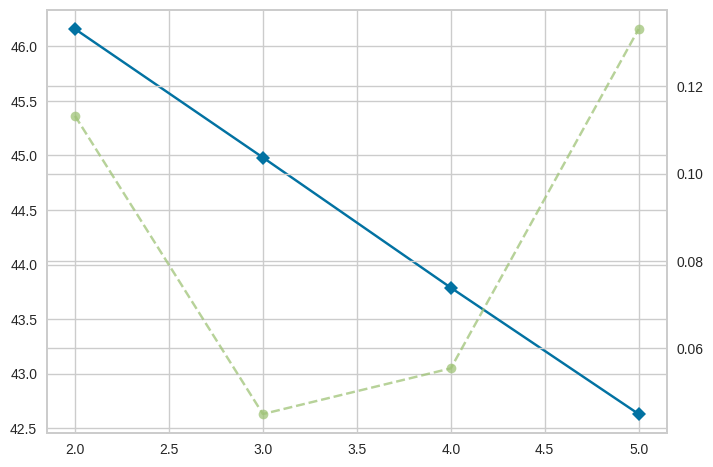

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
km = cluster.KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,6))

visualizer.fit(df)
visualizer.show

Dari elbow method, tidak dapat diambil kesimpulan apa-apa karena tidak terlihat elbow atau sikut pada grafik.

#### Silhouette Score

Menggunakan metode lain untuk mencari nilai *k* yang optimal, yaitu dengan mencari silhouette score dari masing-masing nilai *k*. Silhouette score menunjukkan seberapa mirip suatu objek ke clusternya terhadap cluster lainnya.

In [ ]:
avg_dict = dict()
for n_clusters, kmeans in kmeans_results.items():
  kmeans_labels = kmeans.predict(df)
  silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
  avg_dict.update( {silhouette_avg : n_clusters} )

Avg = []
Ks = []

for avg in sorted(avg_dict.keys(), reverse=True):
  Avg.append(avg.round(4))
  Ks.append(avg_dict[avg])

#Bentuk menjadi tabel
silhoutte_list = pd.DataFrame(
    {'K' : Ks,
     'Average' : Avg
     })

#Urutkan dari besar ke terkecil
silhoutte_list = silhoutte_list.sort_values(by=['K'])
silhoutte_list

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,K,Average
2,2,0.0055
4,3,0.0043
3,4,0.0048
0,5,0.0063
1,6,0.0056


<function matplotlib.pyplot.show(close=None, block=None)>

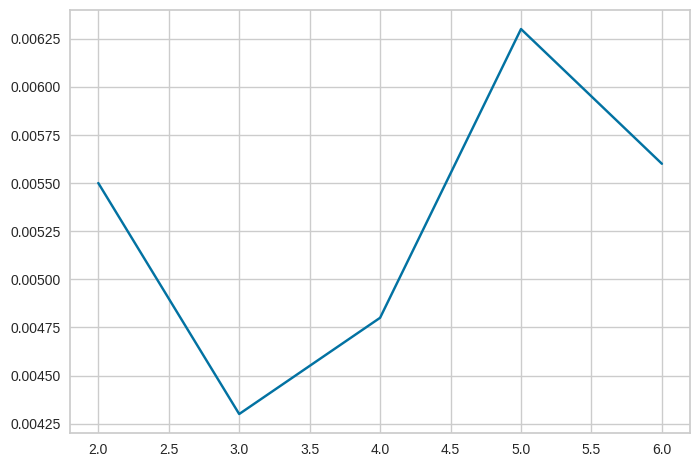

In [ ]:
#plot average
plt.plot(silhoutte_list.K, silhoutte_list.Average)
plt.show

Dari plot di atas, terlihat bahwa nilai *k* dengan silhouette score tertinggi adalah 5. Dengan demikian, banyaknya cluster 5 buah adalah yang paling optimal.

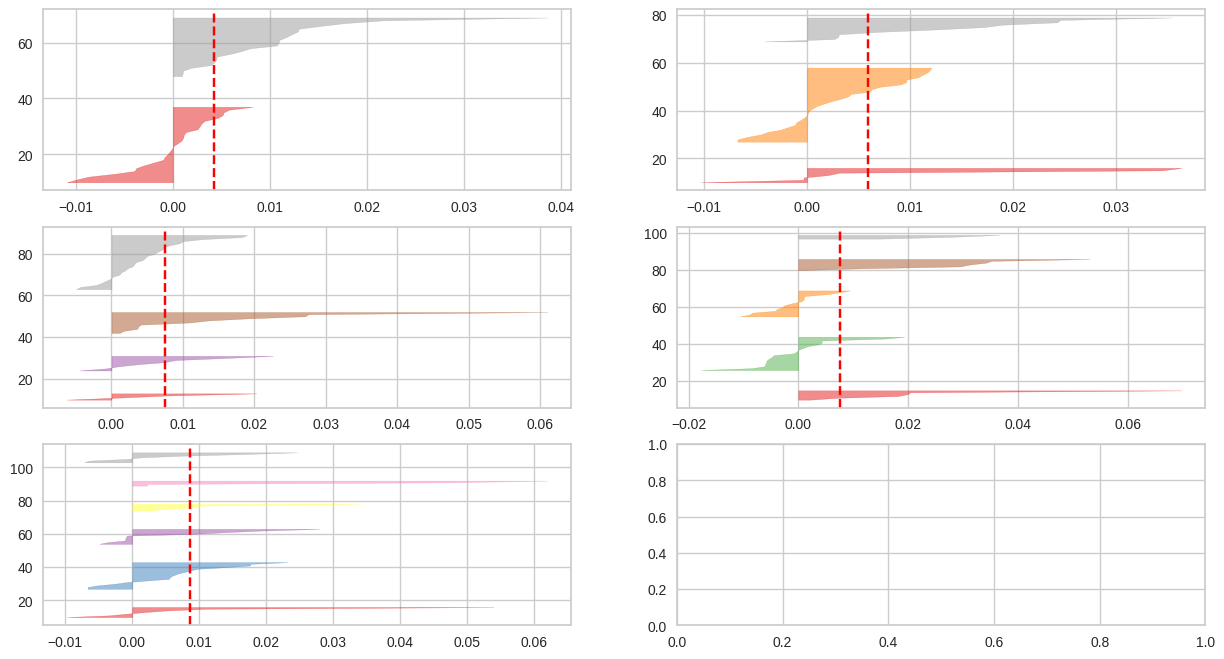

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2,3,4,5,6]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''

    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax= ax[q-1][mod])
    visualizer.fit(df)

Dari plot di atas, terlihat bahwa banyaknya cluster 5 merupakan grafik yang paling dekat dengan garis putus-putus berwarna merah, sehingga nilai tersebut yang paling optimal.

## **Cluster Analysis**

Diperoleh *k=5* sebagai banyaknya cluster terbaik. Selanjutnya, akan diplot 5 kata dengan frekuensi muncul terbanyak pada tiap cluster.

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

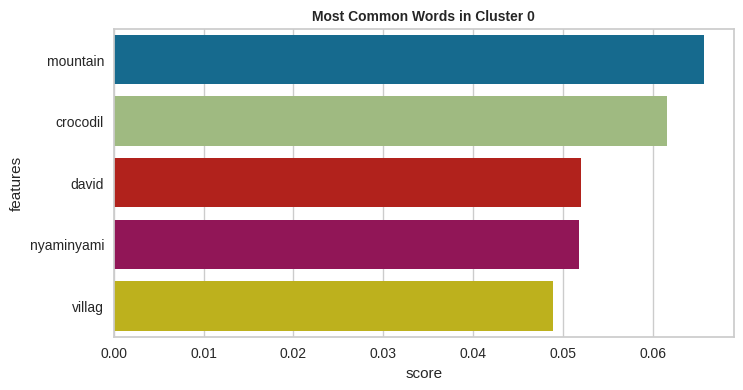

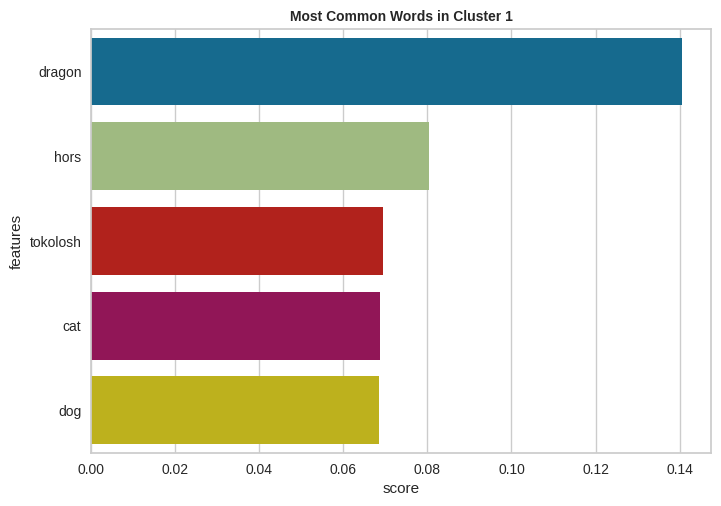

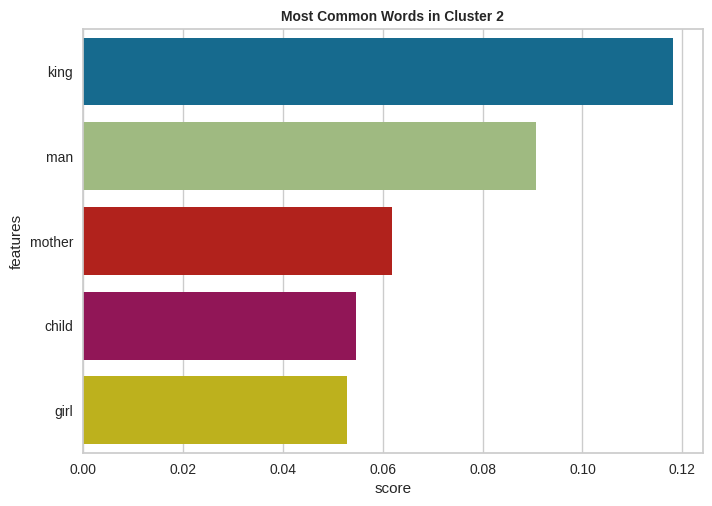

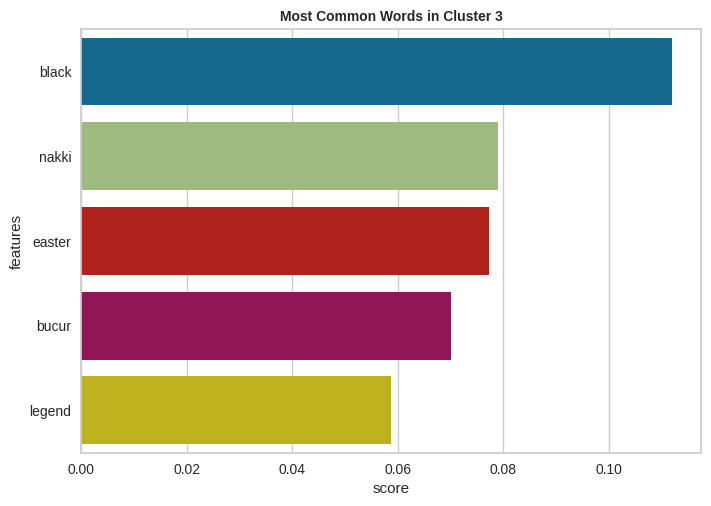

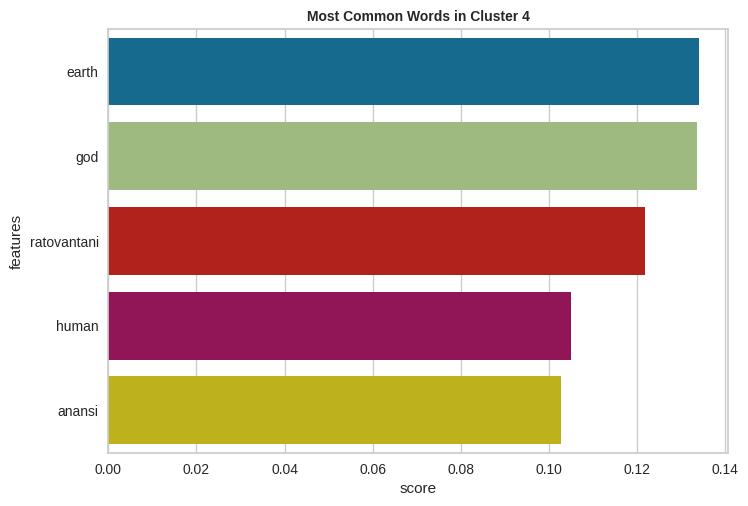

In [ ]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 5)

#### Map of Words

Untuk lebih jelas melihat frekuensi kata-kata pada tiap cluster, dibuat wordcloud yang akan menampilkan kata-kata yang semakin sering muncul dengan ukuran dan ketebalan yang semakin besar.

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'black', colormap='Set2')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

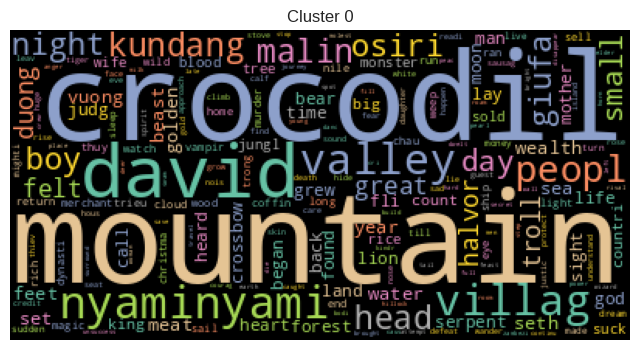

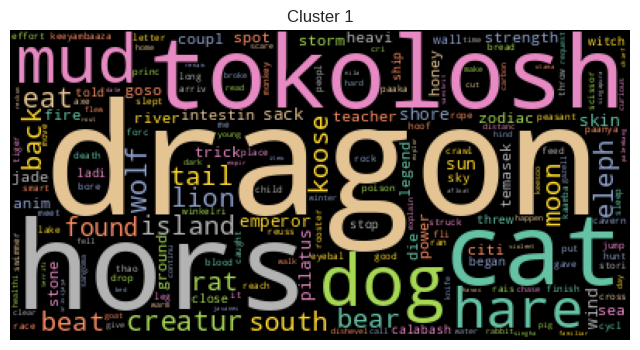

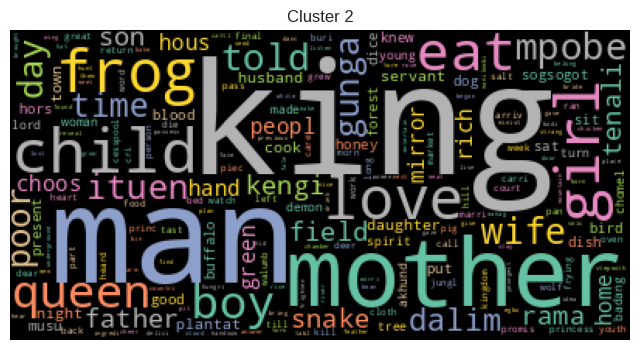

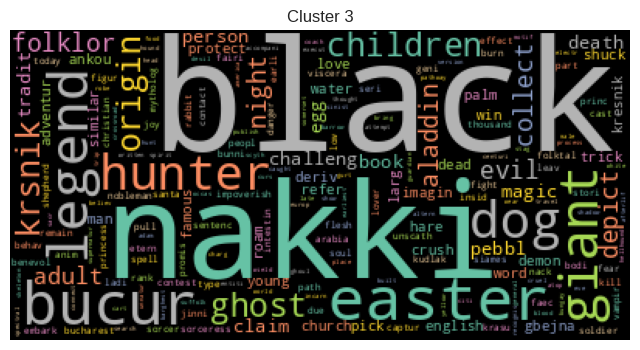

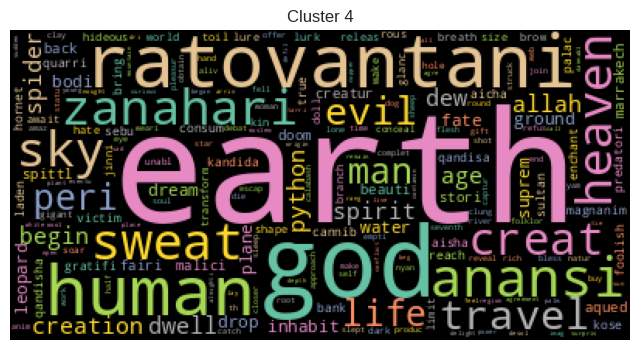

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

### Persiapan Visualisasi Akhir

Selanjutnya, dilakukan fiture engineering, yaitu dengan menambahkan suatu fitur atau variabel baru, yaitu "label". Variabel ini berisi cluster dari setiap negara.

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_
data['label'] = labels
data.head()

,country,alpha-2,alpha-3,continent,title,folklore,label
0,Armenia,AM,ARM,Europe,Dakhanavar,There once dwelt in a cavern in this country a...,0
1,China,CN,CHN,Asia,The Great Race,An ancient folk story tells that Cat (猫) and R...,1
2,Indonesia,ID,IDN,Asia,Malin Kundang,"One day, when Malin Kundang was sailing, he sa...",0
3,Finland,FI,FIN,Europe,Näkki,​Näkki is the most well-known water spirit in ...,3
4,Thailand,TH,THA,Asia,Krasue,"One of Thailand’s most feared ghosts, Krasue w...",3


### Visualisasi Cluster Negara dengan Map

Selanjutnya, akan divisualisasikan cluster dari masing-masing negara ke dalam suatu peta yang interaktif.

Digunakan library Folium dan diload file geoson yang berisikan polygon dan kode negara menggunakan geopandas. Selanjutnya digabungkan dengan "label" yang telah didefinisikan sebelumnya.

In [ ]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3)

,id,name,label,geometry
0,ARM,Armenia,0,"POLYGON ((43.58275 41.09214, 44.97248 41.24813..."
1,BGD,Bangladesh,2,"POLYGON ((92.67272 22.04124, 92.65226 21.32405..."
2,BGR,Bulgaria,2,"POLYGON ((22.65715 44.23492, 22.94483 43.82379..."


Membuat color_step untuk setiap cluster



In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

### Mewarnai Cluster pada Choropleth Map

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m